In [1]:
from __future__ import print_function


import pandas as pd
import numpy as np
import os
import sys
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras import backend as K
import cv2
import copy

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Permute
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, \
    AveragePooling2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Input

In [3]:
#import sys
#del sys.modules['data_generators']

In [4]:
from inputs import *

In [5]:
import data_generators

In [6]:
from models import resnet_50

## Parameters

In [7]:
# Intial .jpg dimensions
x_col, y_col = (256, 937)

# Number of artists to predict
num_classes = df_artists.shape[0]

# Shuffling the datafrmae
shuffle = True
if shuffle:
    df_concat_shuffle = df_concat.sample(frac = 1)
    
# if we can to scale the images (not used)
scaling = 1

# Batch size for the generator
batch_size = 5

# Number of subimages: subimages are, for a given .jpg, we divide the image into "num_subimgs" cuts in the x axis
num_subimgs = 3

# Train / Test split
#split = 0.8

## Instantiate generator: training and testing

### Train/Test split

In [8]:
# Take the name of the track
df_concat_shuffle["tr_id"] = df_concat_shuffle["tr"].str.split("__")
df_concat_shuffle["tr_id"] = df_concat_shuffle["tr_id"].map(lambda x: x[0])

# Impose an ordering to always lead to the same results when replicating it (alphabetical order)
# and also remove duplicates so that the dataframe is of artist - track level
cols = ["art", "tr_id"]
df_art_tr = df_concat_shuffle[cols].drop_duplicates().sort_values(cols)

# Take the groupby of artists taking the last 2 tracks for each artist and marking them with "is_train" = 0
last_2_tr_art = df_art_tr.groupby("art").tail(2).copy()
last_2_tr_art["is_train"] = 0

# Merge back this dataframe of only the last 2 songs with the dataframe with all the image files
df_concat_shuffle = pd.merge(df_concat_shuffle, last_2_tr_art, on = cols, how = "left")

# Since its a left join, replace the NULLS for the "is_train" column for 1 (1= train, 0 = test)
df_concat_shuffle["is_train"] = df_concat_shuffle["is_train"].fillna(1)

# Create the mask to make the split of train /test
msk_split = df_concat_shuffle["is_train"] == 1

# Apply the mask
train = df_concat_shuffle[msk_split].copy()
test = df_concat_shuffle[~msk_split].copy()

# Clean the computed columns
train.drop(["is_train","tr_id"], axis = 1, inplace = True)
test.drop(["is_train","tr_id"], axis = 1, inplace = True)

### Generators

In [9]:
# Training generator
training_generator = data_generators.DataGenerator_subimgs(df=train, 
                                   scaling = scaling,
                                   x_col=x_col, 
                                   y_col=y_col,
                                   batch_size=batch_size, 
                                   num_classes=num_artists,
                                   shuffle=shuffle,
                                   num_subimgs=num_subimgs,
                                   labels = labels)

# Testing generator
testing_generator = data_generators.DataGenerator_subimgs(df=test, 
                                   scaling = scaling,
                                   x_col=x_col, 
                                   y_col=y_col,
                                   batch_size=batch_size, 
                                   num_classes=num_artists,
                                   shuffle=shuffle,
                                   num_subimgs=num_subimgs,
                                   labels=labels)

# Model

In [10]:
# Input shape of the first model layer
in_shape = (int(x_col / (scaling)), int(y_col / (scaling*num_subimgs)), 1)

# Output number of classes
classes = num_artists

## Training parameters

In [11]:
name_model = "Model_DavidAmat_TFM_POPULAR_hard"
epochs = 30
lr = 0.0001
optimizer = Adam(lr=lr)

In [12]:
# Folders to store checkpoints and early stopping criteria
save_metrics_folder='metrics'
save_weights_folder='weights'
load_checkpoint = False
early_stop=10

In [13]:
weights = os.path.join(save_weights_folder, name_model + '_epoch_{epoch:02d}.hdf5')
os.makedirs(save_weights_folder, exist_ok=True)
os.makedirs(save_metrics_folder, exist_ok=True)

### Checkpointing and early stopping

In [14]:
checkpointer = ModelCheckpoint(filepath=weights,
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=True,
                                   period=5,
                                   monitor = 'loss')
earlystopper = EarlyStopping(monitor='loss', min_delta=0,
                             patience=early_stop, verbose=0, mode='auto')

# Compile and Train

In [15]:
# Model
model = resnet_50(in_shape, classes)

In [16]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit_generator(generator = training_generator, epochs=epochs, 
          callbacks=[checkpointer, earlystopper],
          shuffle=True)

Epoch 1/30
2466/2466 [==============================] - 460s 187ms/step - loss: 3.0492 - accuracy: 0.1140
Epoch 2/30
2466/2466 [==============================] - 439s 178ms/step - loss: 2.6636 - accuracy: 0.1981
Epoch 3/30
2466/2466 [==============================] - 443s 180ms/step - loss: 2.4151 - accuracy: 0.2641
Epoch 4/30
2466/2466 [==============================] - 444s 180ms/step - loss: 2.1401 - accuracy: 0.3468
Epoch 5/30
2466/2466 [==============================] - 446s 181ms/step - loss: 1.8649 - accuracy: 0.4258

Epoch 00005: saving model to weights/Model_DavidAmat_TFM_POPULAR_hard_epoch_05.hdf5
Epoch 6/30
2466/2466 [==============================] - 438s 178ms/step - loss: 1.6119 - accuracy: 0.5045
Epoch 7/30
2466/2466 [==============================] - 443s 180ms/step - loss: 1.3861 - accuracy: 0.5718
Epoch 8/30
2466/2466 [==============================] - 439s 178ms/step - loss: 1.1761 - accuracy: 0.6308
Epoch 9/30
2466/2466 [==============================] - 437s 177ms/

In [18]:
model.save(f'models/{name_model}.tf')

# Load the model

In [19]:
model = resnet_50(in_shape, classes)

In [20]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.load_weights(f'weights/{name_model}_epoch_30.hdf5')

In [29]:
#model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Evaluate on the testing generator and training

In [22]:
model.evaluate(training_generator)

2466/2466 [==============================] - 116s 47ms/step


[1.1781690120697021, 0.8665044903755188]

In [23]:
model.evaluate(testing_generator)

114/114 [==============================] - 5s 46ms/step


[5.113783836364746, 0.31461986899375916]

# Embeddings

In [24]:
embed_model = copy.copy(model)
embed_model.layers.pop()

In [28]:
from tqdm.notebook import tqdm

In [29]:
def get_img_predict_subimgs(img, art, x_col, y_col, scaling, num_subimgs, jj):
    path_img = os.path.join(PATH_DATA, img)
    img = cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2GRAY)
    img = np.round(img / 255.,5)
    dim = (int(x_col / scaling), int(y_col / scaling), 1) #one input channel
    img = cv2.resize(img, (y_col, x_col))
    
    y_subimgs = int(np.floor(y_col / num_subimgs))
    positions_cut_img = np.arange(0, y_col, y_subimgs)
    subimg = img[:,positions_cut_img[jj]:positions_cut_img[jj+1]]
    subimg = np.expand_dims(subimg, axis = 2) # add the dimension of the channel 
    subimg = np.expand_dims(subimg, axis = 0)
    return subimg, labels[art]

In [30]:
def get_dict_pred(df_train_test, is_train, dict_pred):
    
    # If is_train then
    if is_train:
        size_point = 50
    else:
        size_point = 200
    
    for _, row in tqdm(df_train_test.iterrows()):
        art, img, win, ini, fin = row

        # Store in dictionary
        dict_pred[art][img] = dict()

        for jj in range(num_subimgs - 1):

            # Get the image and the artist id
            img_matrix, label_real  = get_img_predict_subimgs(img, art, x_col, y_col, scaling, num_subimgs, jj)

            # Get the predictions
            predictions = model.predict(img_matrix)

            # Get the position of the label
            position_label_pred = np.argmax(predictions)
            position_label_real = np.argmax(label_real)

            # True prediction
            true_pred = 1 if position_label_pred == position_label_real else 0

            # Compute the embedding
            embedding = embed_model.predict(img_matrix)

            # Store in dictionary
            dict_pred[art][img][jj] = dict()
            dict_pred[art][img][jj]["true_pred"] = true_pred
            dict_pred[art][img][jj]["position_label_real"] = position_label_real
            dict_pred[art][img][jj]["position_label_pred"] = position_label_pred
            dict_pred[art][img][jj]["predictions"] = predictions
            dict_pred[art][img][jj]["label_real"] = label_real
            dict_pred[art][img][jj]["embedding"] = embedding
            dict_pred[art][img][jj]["size_point"] = size_point
            dict_pred[art][img][jj]["is_train"] = is_train
            
    return dict_pred

In [35]:
dict_pred = defaultdict(dict)

# Train
dict_pred = get_dict_pred(train, 1, dict_pred)
dict_pred = get_dict_pred(test, 0, dict_pred)

In [36]:
import pickle
PATH_DICT = "outputs"

with open(os.path.join(PATH_DICT, 'dict_popular_hard.pickle'), 'wb') as handle:
    pickle.dump(dict_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Representation

## Dataframe for embeddings

In [38]:
values = []
edgecolors = {'train': "#1A1717", 'test': "#EE3811"} # test: rojo, train: negro

for art in tqdm(dict_pred):
    for tr in dict_pred[art]:
        for jj in range(num_subimgs - 1):
            size = dict_pred[art][tr][jj]["size_point"]
            alpha = edgecolors["train"] if size == 50 else edgecolors["test"]
            l = [art, tr, jj, size, alpha]
            for embed_val in dict_pred[art][tr][jj]["embedding"]:
                l.append(embed_val)
            values.append(l)

In [39]:
df_tsne = pd.DataFrame(values, columns = ["art","img","subimg","size_point","alpha", "embed"])

In [40]:
vals = []
for ll in df_tsne.embed:
    vals.append(list(ll))
vals_arr = np.array(vals)

## t-SNE

In [41]:
tsne_model = TSNE()
X_2d = tsne_model.fit_transform(vals_arr)

In [42]:
original_artist = np.array(df_tsne.art)

In [43]:
colors_extra = ["#800000","#9A6324","#808000","#EFD2CB","#469990",
                "#000075","#000000","#e6194B","#f58231","#ffe119","#bfef45",
                "#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4",
                "#ffd8b1","#fffac8","#aaffc3","#dcbeff","#0B0033","#370031","#832232","#CE8964","#EAF27C"
                ]

colors_extra = colors_extra[:num_artists]

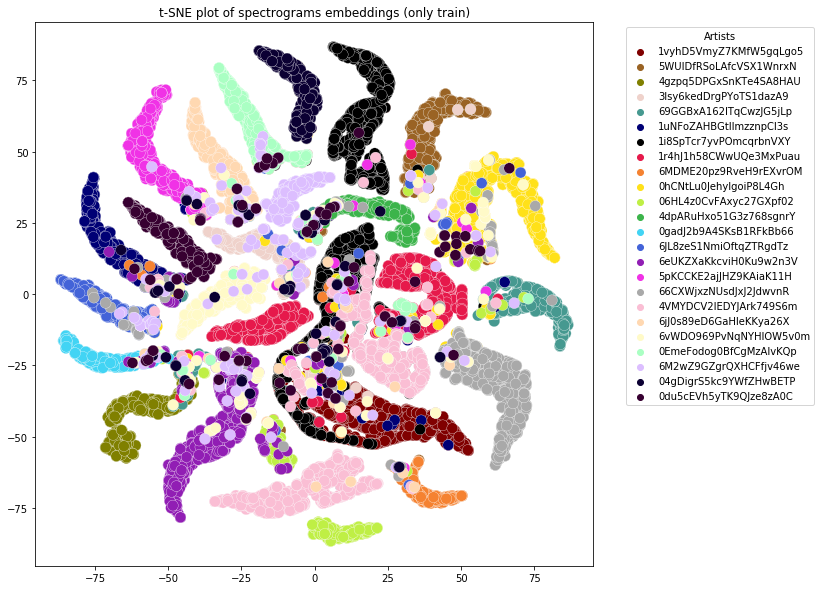

In [44]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 0.3,
                palette=sns.color_palette(colors_extra))
plt.title('t-SNE plot of spectrograms embeddings (only train)')
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')

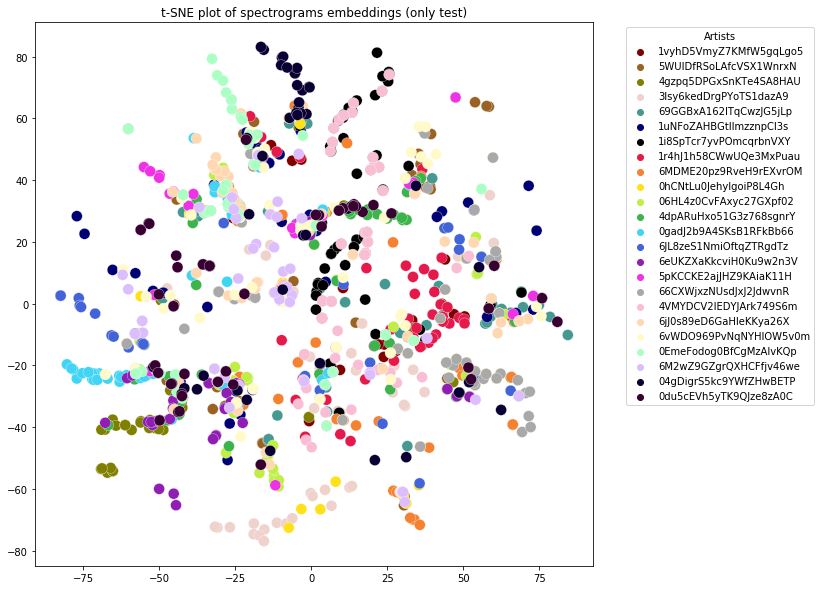

In [45]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 0.3,
                palette=sns.color_palette(colors_extra))
plt.title('t-SNE plot of spectrograms embeddings (only test)')
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')

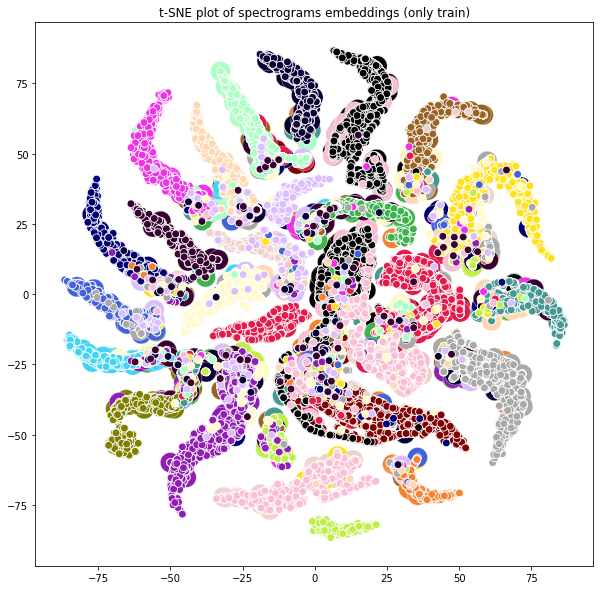

In [46]:
plt.figure(figsize=(10,10))

# Test
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 400, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 0.3,
                palette=sns.color_palette(colors_extra))
plt.title('t-SNE plot of spectrograms embeddings (only train)')
#leg = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')
#Train
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 60, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 0.8,
                palette=sns.color_palette(colors_extra))
#leg.set_bbox_to_anchor((1.05, 1))
plt.legend('',frameon=False)

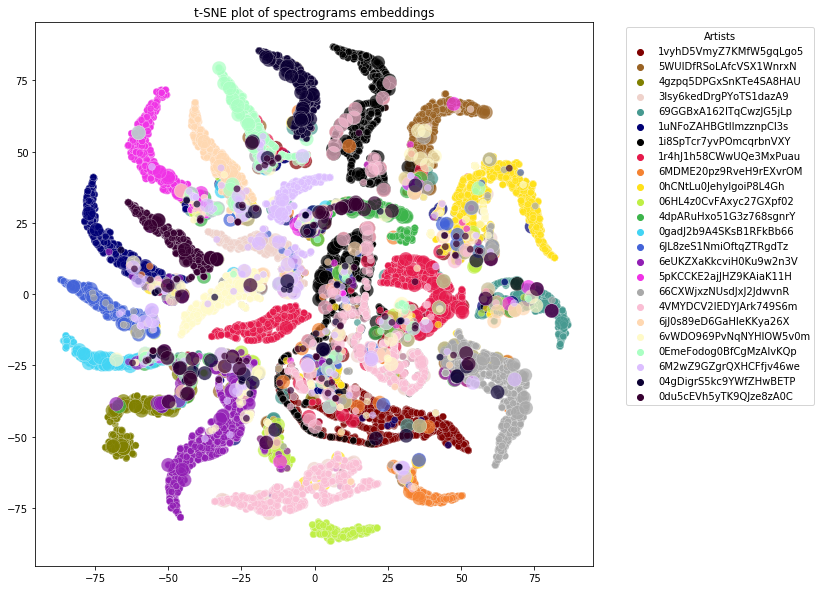

In [47]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=original_artist, 
                s= df_tsne["size_point"], alpha = 0.7, edgecolors=df_tsne["alpha"], linewidth = 0.3,
                palette=sns.color_palette(colors_extra))
plt.title('t-SNE plot of spectrograms embeddings')
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')

In [41]:
# Free GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()